In [1]:
%%writefile data_loader.py

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset, DataLoader


class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoded_text = self.tokenizer(text)

        x = torch.tensor(encoded_text, dtype=torch.long)
        y = torch.tensor(label, dtype=torch.long)
        return x, y

def load_data(file_path, tokenizer, test_size=0.2):
    df = pd.read_csv(file_path)
    #df = df.sample(n=1000, random_state=19)  # for test
    X_train, X_test, y_train, y_test = train_test_split(
        df['TITLE'], df['CATEGORY'], test_size=test_size, random_state=27
    )

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    dataset_trn = NewsDataset(X_train.values, y_train, tokenizer)
    dataset_tst = NewsDataset(X_test.values, y_test, tokenizer)

    return dataset_trn, dataset_tst, le

Overwriting data_loader.py


In [2]:
%%writefile model.py

import torch
import torch.nn as nn
import torch.nn.functional as F


class NewsClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)  # Experiment with other pooling methods
        return self.fc(x)


Overwriting model.py


In [3]:
%%writefile train.py

import logging
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from evaluate import evaluate

# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger(__name__)

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    train_loss, test_loss = [], []
    train_acc, test_acc = [], []

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        test_epoch_loss, test_epoch_acc = evaluate(model, test_loader, criterion, device)
        test_loss.append(test_epoch_loss)
        test_acc.append(test_epoch_acc)

        # print(f'# Epoch {epoch}/{num_epochs} ======================= #')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | Test Loss: {test_epoch_loss:.4f} - Test Acc: {test_epoch_acc:.4f}\n')

    return train_loss, train_acc, test_loss, test_acc

Overwriting train.py


In [4]:
%%writefile evaluate.py

import torch

def evaluate(model, loader, criterion, device):
    model.to(device)
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.inference_mode():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader.dataset), correct / total

Overwriting evaluate.py


In [5]:
%%writefile utils.py

import matplotlib.pyplot as plt

def plot_curves(train_loss, train_acc, test_loss, test_acc, save_path='training_curves.png'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    epochs = range(1, len(train_loss) + 1)

    def plot_metric(ax, y_train, y_test, title, ylabel):
        ax.plot(epochs, y_train, label='Train')
        ax.plot(epochs, y_test, label='Test')
        ax.set_title(title)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(ylabel)
        ax.legend()

        # Show every other epoch (or at least two ticks)
        step = max(2, len(epochs) // 10)  # Adjust step size for large epochs
        ax.set_xticks(list(epochs)[::step])

    plot_metric(axes[0], train_loss, test_loss, 'Validation Curves', 'Loss')
    plot_metric(axes[1], train_acc, test_acc, 'Accuracy Progression', 'Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f'*** Plot saved to: {save_path} ***')

    plt.show()
    plt.close()  # Free memory


Overwriting utils.py


In [6]:
%%writefile main.py

import argparse

import torch
from torch.utils.data import DataLoader

from data_loader import load_data
from model import NewsClassifier
from train import train
from utils import plot_curves


class SimpleTokenizer:
    def __init__(self, max_len=50, vocab_size=128, pad_idx=0, unk_idx=1):
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.unk_idx = unk_idx

    def __call__(self, text):
        # Encode each character; replace out-of-vocabulary with unk_idx
        encoded = [ord(chr) if ord(chr) < self.vocab_size else self.unk_idx for chr in text[:self.max_len]]

        # Pad to max_len if needed
        if len(encoded) < self.max_len:
            encoded.extend([self.max_len] * (self.max_len - len(encoded)))

        return encoded

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Train a News Classifier')
    parser.add_argument('--data_path', type=str, help='path to training data')
    parser.add_argument('--num_epochs', type=int, default=10, help='number of epochs for training')
    parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
    args = parser.parse_args()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'using ***{device}***')

    tokenizer = SimpleTokenizer(max_len=50)
    train_dataset, test_dataset, label_encoder = load_data(args.data_path, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    vocab_size = 128  # ASCII size
    embed_dim = 128
    num_classes = len(label_encoder.classes_)
    # UNK_IDX = vocab_size - 2  # Reserve the last index for unknown tokens
    tokenizers_param = {
        'pad_idx': 0,
        'unk_idx': vocab_size - 2
    }
    model = NewsClassifier(vocab_size, embed_dim, num_classes)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_loss, train_acc, test_loss, test_acc = train(model,
                                                      train_loader,
                                                      test_loader,
                                                      criterion,
                                                      optimizer,
                                                      num_epochs=args.num_epochs,
                                                      device=device)

    plot_curves(train_loss, train_acc, test_loss, test_acc)

Overwriting main.py


In [7]:
!python main.py --data_path "./news_agg_dataset_42k.csv" --learning_rate 1e-2 --num_epochs 50

using ***cuda***
Epoch 1/50: 100% 53/53 [00:00<00:00, 78.63it/s] 
Train Loss: 1.3409, Train Acc: 0.3229 | Test Loss: 1.3174 - Test Acc: 0.3373

Epoch 2/50: 100% 53/53 [00:00<00:00, 208.44it/s]
Train Loss: 1.2901, Train Acc: 0.3785 | Test Loss: 1.2974 - Test Acc: 0.3751

Epoch 3/50: 100% 53/53 [00:00<00:00, 251.70it/s]
Train Loss: 1.2705, Train Acc: 0.4146 | Test Loss: 1.2797 - Test Acc: 0.3964

Epoch 4/50: 100% 53/53 [00:00<00:00, 163.59it/s]
Train Loss: 1.2528, Train Acc: 0.4253 | Test Loss: 1.2575 - Test Acc: 0.4627

Epoch 5/50: 100% 53/53 [00:00<00:00, 142.91it/s]
Train Loss: 1.2352, Train Acc: 0.4569 | Test Loss: 1.2436 - Test Acc: 0.4592

Epoch 6/50: 100% 53/53 [00:00<00:00, 160.36it/s]
Train Loss: 1.2174, Train Acc: 0.4711 | Test Loss: 1.2290 - Test Acc: 0.4710

Epoch 7/50: 100% 53/53 [00:00<00:00, 144.48it/s]
Train Loss: 1.2024, Train Acc: 0.4803 | Test Loss: 1.2106 - Test Acc: 0.4911

Epoch 8/50: 100% 53/53 [00:00<00:00, 258.85it/s]
Train Loss: 1.1860, Train Acc: 0.4898 | Test 

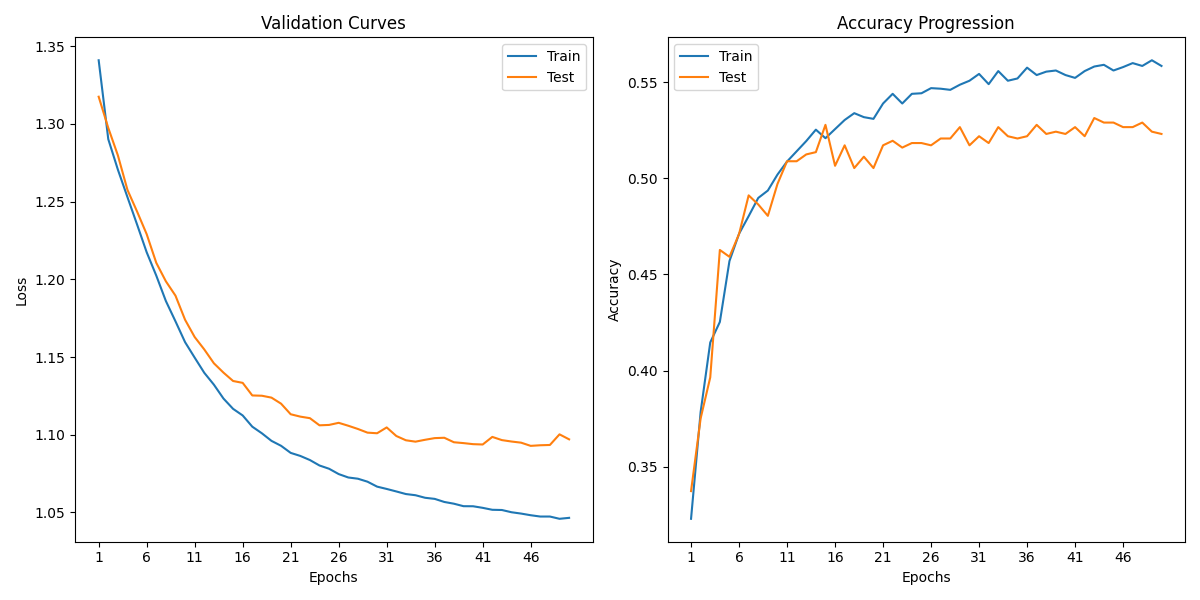

In [8]:
from IPython.display import Image, display

display(Image(filename='training_curves.png'))

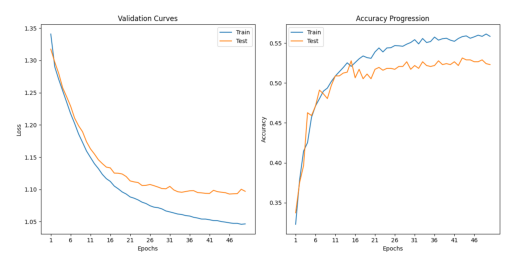

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('training_curves.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
!python main.py --data_path "./news_agg_dataset_42k.csv" --learning_rate 1e-3 --num_epochs 30

using ***cuda***
Epoch 1/30: 100% 53/53 [00:00<00:00, 120.03it/s]
Train Loss: 1.3164, Train Acc: 0.3560 | Test Loss: 1.3161 - Test Acc: 0.3243

Epoch 2/30: 100% 53/53 [00:00<00:00, 370.78it/s]
Train Loss: 1.2863, Train Acc: 0.3868 | Test Loss: 1.2907 - Test Acc: 0.3609

Epoch 3/30: 100% 53/53 [00:00<00:00, 364.01it/s]
Train Loss: 1.2654, Train Acc: 0.4037 | Test Loss: 1.2682 - Test Acc: 0.4391

Epoch 4/30: 100% 53/53 [00:00<00:00, 359.15it/s]
Train Loss: 1.2482, Train Acc: 0.4410 | Test Loss: 1.2498 - Test Acc: 0.4521

Epoch 5/30: 100% 53/53 [00:00<00:00, 374.34it/s]
Train Loss: 1.2296, Train Acc: 0.4566 | Test Loss: 1.2359 - Test Acc: 0.4462

Epoch 6/30: 100% 53/53 [00:00<00:00, 376.88it/s]
Train Loss: 1.2133, Train Acc: 0.4626 | Test Loss: 1.2166 - Test Acc: 0.4734

Epoch 7/30: 100% 53/53 [00:00<00:00, 366.75it/s]
Train Loss: 1.1980, Train Acc: 0.4774 | Test Loss: 1.2009 - Test Acc: 0.4970

Epoch 8/30: 100% 53/53 [00:00<00:00, 376.28it/s]
Train Loss: 1.1821, Train Acc: 0.4907 | Test 

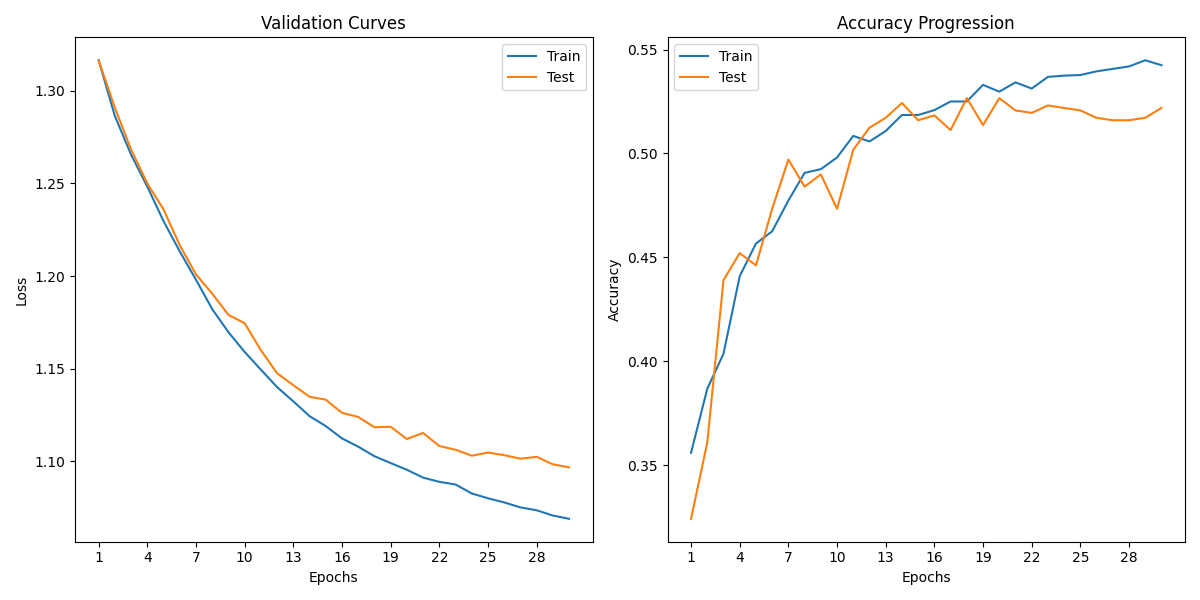

In [11]:
from IPython.display import Image, display

display(Image(filename='training_curves.png'))